# Machine Learning Engineer Nanodegree
## House Prices: Advanced Regression Techniques

In [59]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Pretty display for notebooks
%matplotlib inline

# Load training data
data = pd.read_csv('housing/train.csv')
test_data = pd.read_csv('housing/test.csv')

# Basic exploration
print("The housing dataset has {} data points with {} variables each.".format(*data.shape))
data.head(10)

The housing dataset has 1460 data points with 81 variables each.


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [98]:
# One hot encode data for data analysis
# Remove "NaN" values so our predict() functions
# don't cause errors
encoded_data = pd.get_dummies(data).replace(np.NaN, 0)
encoded_data_y = encoded_data.SalePrice
encoded_data = encoded_data.drop(['Id'], axis=1)
encoded_test_data = pd.get_dummies(test_data).replace(np.NaN, 0)

# Find top 10 strongest correlations (+/- included)
corr_values = encoded_data.corr().filter(['SalePrice']).drop(['SalePrice'])
corr_values = corr_values.abs()
corr_values.sort_values(by=['SalePrice'], ascending=False).head(10)


,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
ExterQual_TA,0.589044
FullBath,0.560664
BsmtQual_Ex,0.553105
TotRmsAbvGrd,0.533723


In [47]:
def detect_outliers(columns, data):
    outliers = []

    for feature in columns:

        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(data[feature], 25)

        Q2 = np.percentile(data[feature], 50)

        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(data[feature], 75)

        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = (Q3-Q1) * 1.5

        # Display the outliers
        print "Data points considered outliers for the feature '{}':".format(feature)
        df = data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))]
        display("{} median: {}".format(feature, Q2))
        display("{} step: {}".format(feature, step))
        display("{} number found: {}".format(feature, len(df.index.tolist())))
        #display(data[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))])
        items = df.Id.tolist()
        outliers.append((feature, items))
    return outliers

In [56]:
ids = detect_outliers([x for x in encoded_data], encoded_data)

Data points considered outliers for the feature 'Id':


'Id median: 730.5'

'Id step: 1094.25'

'Id number found: 0'

Data points considered outliers for the feature 'MSSubClass':


'MSSubClass median: 50.0'

'MSSubClass step: 75.0'

'MSSubClass number found: 103'

Data points considered outliers for the feature 'LotFrontage':


'LotFrontage median: 63.0'

'LotFrontage step: 55.5'

'LotFrontage number found: 16'

Data points considered outliers for the feature 'LotArea':


'LotArea median: 9478.5'

'LotArea step: 6072.0'

'LotArea number found: 69'

Data points considered outliers for the feature 'OverallQual':


'OverallQual median: 6.0'

'OverallQual step: 3.0'

'OverallQual number found: 2'

Data points considered outliers for the feature 'OverallCond':


'OverallCond median: 5.0'

'OverallCond step: 1.5'

'OverallCond number found: 125'

Data points considered outliers for the feature 'YearBuilt':


'YearBuilt median: 1973.0'

'YearBuilt step: 69.0'

'YearBuilt number found: 7'

Data points considered outliers for the feature 'YearRemodAdd':


'YearRemodAdd median: 1994.0'

'YearRemodAdd step: 55.5'

'YearRemodAdd number found: 0'

Data points considered outliers for the feature 'MasVnrArea':


'MasVnrArea median: 0.0'

'MasVnrArea step: 246.375'

'MasVnrArea number found: 98'

Data points considered outliers for the feature 'BsmtFinSF1':


'BsmtFinSF1 median: 383.5'

'BsmtFinSF1 step: 1068.375'

'BsmtFinSF1 number found: 7'

Data points considered outliers for the feature 'BsmtFinSF2':


'BsmtFinSF2 median: 0.0'

'BsmtFinSF2 step: 0.0'

'BsmtFinSF2 number found: 167'

Data points considered outliers for the feature 'BsmtUnfSF':


'BsmtUnfSF median: 477.5'

'BsmtUnfSF step: 877.5'

'BsmtUnfSF number found: 29'

Data points considered outliers for the feature 'TotalBsmtSF':


'TotalBsmtSF median: 991.5'

'TotalBsmtSF step: 753.75'

'TotalBsmtSF number found: 61'

Data points considered outliers for the feature '1stFlrSF':


'1stFlrSF median: 1087.0'

'1stFlrSF step: 763.875'

'1stFlrSF number found: 20'

Data points considered outliers for the feature '2ndFlrSF':


'2ndFlrSF median: 0.0'

'2ndFlrSF step: 1092.0'

'2ndFlrSF number found: 2'

Data points considered outliers for the feature 'LowQualFinSF':


'LowQualFinSF median: 0.0'

'LowQualFinSF step: 0.0'

'LowQualFinSF number found: 26'

Data points considered outliers for the feature 'GrLivArea':


'GrLivArea median: 1464.0'

'GrLivArea step: 970.875'

'GrLivArea number found: 31'

Data points considered outliers for the feature 'BsmtFullBath':


'BsmtFullBath median: 0.0'

'BsmtFullBath step: 1.5'

'BsmtFullBath number found: 1'

Data points considered outliers for the feature 'BsmtHalfBath':


'BsmtHalfBath median: 0.0'

'BsmtHalfBath step: 0.0'

'BsmtHalfBath number found: 82'

Data points considered outliers for the feature 'FullBath':


'FullBath median: 2.0'

'FullBath step: 1.5'

'FullBath number found: 0'

Data points considered outliers for the feature 'HalfBath':


'HalfBath median: 0.0'

'HalfBath step: 1.5'

'HalfBath number found: 0'

Data points considered outliers for the feature 'BedroomAbvGr':


'BedroomAbvGr median: 3.0'

'BedroomAbvGr step: 1.5'

'BedroomAbvGr number found: 35'

Data points considered outliers for the feature 'KitchenAbvGr':


'KitchenAbvGr median: 1.0'

'KitchenAbvGr step: 0.0'

'KitchenAbvGr number found: 68'

Data points considered outliers for the feature 'TotRmsAbvGrd':


'TotRmsAbvGrd median: 6.0'

'TotRmsAbvGrd step: 3.0'

'TotRmsAbvGrd number found: 30'

Data points considered outliers for the feature 'Fireplaces':


'Fireplaces median: 1.0'

'Fireplaces step: 1.5'

'Fireplaces number found: 5'

Data points considered outliers for the feature 'GarageYrBlt':


'GarageYrBlt median: 1977.0'

'GarageYrBlt step: 64.5'

'GarageYrBlt number found: 81'

Data points considered outliers for the feature 'GarageCars':


'GarageCars median: 2.0'

'GarageCars step: 1.5'

'GarageCars number found: 5'

Data points considered outliers for the feature 'GarageArea':


'GarageArea median: 480.0'

'GarageArea step: 362.25'

'GarageArea number found: 21'

Data points considered outliers for the feature 'WoodDeckSF':


'WoodDeckSF median: 0.0'

'WoodDeckSF step: 252.0'

'WoodDeckSF number found: 32'

Data points considered outliers for the feature 'OpenPorchSF':


'OpenPorchSF median: 25.0'

'OpenPorchSF step: 102.0'

'OpenPorchSF number found: 77'

Data points considered outliers for the feature 'EnclosedPorch':


'EnclosedPorch median: 0.0'

'EnclosedPorch step: 0.0'

'EnclosedPorch number found: 208'

Data points considered outliers for the feature '3SsnPorch':


'3SsnPorch median: 0.0'

'3SsnPorch step: 0.0'

'3SsnPorch number found: 24'

Data points considered outliers for the feature 'ScreenPorch':


'ScreenPorch median: 0.0'

'ScreenPorch step: 0.0'

'ScreenPorch number found: 116'

Data points considered outliers for the feature 'PoolArea':


'PoolArea median: 0.0'

'PoolArea step: 0.0'

'PoolArea number found: 7'

Data points considered outliers for the feature 'MiscVal':


'MiscVal median: 0.0'

'MiscVal step: 0.0'

'MiscVal number found: 52'

Data points considered outliers for the feature 'MoSold':


'MoSold median: 6.0'

'MoSold step: 4.5'

'MoSold number found: 0'

Data points considered outliers for the feature 'YrSold':


'YrSold median: 2008.0'

'YrSold step: 3.0'

'YrSold number found: 0'

Data points considered outliers for the feature 'SalePrice':


'SalePrice median: 163000.0'

'SalePrice step: 126037.5'

'SalePrice number found: 61'

Data points considered outliers for the feature 'MSZoning_C (all)':


'MSZoning_C (all) median: 0.0'

'MSZoning_C (all) step: 0.0'

'MSZoning_C (all) number found: 10'

Data points considered outliers for the feature 'MSZoning_FV':


'MSZoning_FV median: 0.0'

'MSZoning_FV step: 0.0'

'MSZoning_FV number found: 65'

Data points considered outliers for the feature 'MSZoning_RH':


'MSZoning_RH median: 0.0'

'MSZoning_RH step: 0.0'

'MSZoning_RH number found: 16'

Data points considered outliers for the feature 'MSZoning_RL':


'MSZoning_RL median: 1.0'

'MSZoning_RL step: 0.0'

'MSZoning_RL number found: 309'

Data points considered outliers for the feature 'MSZoning_RM':


'MSZoning_RM median: 0.0'

'MSZoning_RM step: 0.0'

'MSZoning_RM number found: 218'

Data points considered outliers for the feature 'Street_Grvl':


'Street_Grvl median: 0.0'

'Street_Grvl step: 0.0'

'Street_Grvl number found: 6'

Data points considered outliers for the feature 'Street_Pave':


'Street_Pave median: 1.0'

'Street_Pave step: 0.0'

'Street_Pave number found: 6'

Data points considered outliers for the feature 'Alley_Grvl':


'Alley_Grvl median: 0.0'

'Alley_Grvl step: 0.0'

'Alley_Grvl number found: 50'

Data points considered outliers for the feature 'Alley_Pave':


'Alley_Pave median: 0.0'

'Alley_Pave step: 0.0'

'Alley_Pave number found: 41'

Data points considered outliers for the feature 'LotShape_IR1':


'LotShape_IR1 median: 0.0'

'LotShape_IR1 step: 1.5'

'LotShape_IR1 number found: 0'

Data points considered outliers for the feature 'LotShape_IR2':


'LotShape_IR2 median: 0.0'

'LotShape_IR2 step: 0.0'

'LotShape_IR2 number found: 41'

Data points considered outliers for the feature 'LotShape_IR3':


'LotShape_IR3 median: 0.0'

'LotShape_IR3 step: 0.0'

'LotShape_IR3 number found: 10'

Data points considered outliers for the feature 'LotShape_Reg':


'LotShape_Reg median: 1.0'

'LotShape_Reg step: 1.5'

'LotShape_Reg number found: 0'

Data points considered outliers for the feature 'LandContour_Bnk':


'LandContour_Bnk median: 0.0'

'LandContour_Bnk step: 0.0'

'LandContour_Bnk number found: 63'

Data points considered outliers for the feature 'LandContour_HLS':


'LandContour_HLS median: 0.0'

'LandContour_HLS step: 0.0'

'LandContour_HLS number found: 50'

Data points considered outliers for the feature 'LandContour_Low':


'LandContour_Low median: 0.0'

'LandContour_Low step: 0.0'

'LandContour_Low number found: 36'

Data points considered outliers for the feature 'LandContour_Lvl':


'LandContour_Lvl median: 1.0'

'LandContour_Lvl step: 0.0'

'LandContour_Lvl number found: 149'

Data points considered outliers for the feature 'Utilities_AllPub':


'Utilities_AllPub median: 1.0'

'Utilities_AllPub step: 0.0'

'Utilities_AllPub number found: 1'

Data points considered outliers for the feature 'Utilities_NoSeWa':


'Utilities_NoSeWa median: 0.0'

'Utilities_NoSeWa step: 0.0'

'Utilities_NoSeWa number found: 1'

Data points considered outliers for the feature 'LotConfig_Corner':


'LotConfig_Corner median: 0.0'

'LotConfig_Corner step: 0.0'

'LotConfig_Corner number found: 263'

Data points considered outliers for the feature 'LotConfig_CulDSac':


'LotConfig_CulDSac median: 0.0'

'LotConfig_CulDSac step: 0.0'

'LotConfig_CulDSac number found: 94'

Data points considered outliers for the feature 'LotConfig_FR2':


'LotConfig_FR2 median: 0.0'

'LotConfig_FR2 step: 0.0'

'LotConfig_FR2 number found: 47'

Data points considered outliers for the feature 'LotConfig_FR3':


'LotConfig_FR3 median: 0.0'

'LotConfig_FR3 step: 0.0'

'LotConfig_FR3 number found: 4'

Data points considered outliers for the feature 'LotConfig_Inside':


'LotConfig_Inside median: 1.0'

'LotConfig_Inside step: 1.5'

'LotConfig_Inside number found: 0'

Data points considered outliers for the feature 'LandSlope_Gtl':


'LandSlope_Gtl median: 1.0'

'LandSlope_Gtl step: 0.0'

'LandSlope_Gtl number found: 78'

Data points considered outliers for the feature 'LandSlope_Mod':


'LandSlope_Mod median: 0.0'

'LandSlope_Mod step: 0.0'

'LandSlope_Mod number found: 65'

Data points considered outliers for the feature 'LandSlope_Sev':


'LandSlope_Sev median: 0.0'

'LandSlope_Sev step: 0.0'

'LandSlope_Sev number found: 13'

Data points considered outliers for the feature 'Neighborhood_Blmngtn':


'Neighborhood_Blmngtn median: 0.0'

'Neighborhood_Blmngtn step: 0.0'

'Neighborhood_Blmngtn number found: 17'

Data points considered outliers for the feature 'Neighborhood_Blueste':


'Neighborhood_Blueste median: 0.0'

'Neighborhood_Blueste step: 0.0'

'Neighborhood_Blueste number found: 2'

Data points considered outliers for the feature 'Neighborhood_BrDale':


'Neighborhood_BrDale median: 0.0'

'Neighborhood_BrDale step: 0.0'

'Neighborhood_BrDale number found: 16'

Data points considered outliers for the feature 'Neighborhood_BrkSide':


'Neighborhood_BrkSide median: 0.0'

'Neighborhood_BrkSide step: 0.0'

'Neighborhood_BrkSide number found: 58'

Data points considered outliers for the feature 'Neighborhood_ClearCr':


'Neighborhood_ClearCr median: 0.0'

'Neighborhood_ClearCr step: 0.0'

'Neighborhood_ClearCr number found: 28'

Data points considered outliers for the feature 'Neighborhood_CollgCr':


'Neighborhood_CollgCr median: 0.0'

'Neighborhood_CollgCr step: 0.0'

'Neighborhood_CollgCr number found: 150'

Data points considered outliers for the feature 'Neighborhood_Crawfor':


'Neighborhood_Crawfor median: 0.0'

'Neighborhood_Crawfor step: 0.0'

'Neighborhood_Crawfor number found: 51'

Data points considered outliers for the feature 'Neighborhood_Edwards':


'Neighborhood_Edwards median: 0.0'

'Neighborhood_Edwards step: 0.0'

'Neighborhood_Edwards number found: 100'

Data points considered outliers for the feature 'Neighborhood_Gilbert':


'Neighborhood_Gilbert median: 0.0'

'Neighborhood_Gilbert step: 0.0'

'Neighborhood_Gilbert number found: 79'

Data points considered outliers for the feature 'Neighborhood_IDOTRR':


'Neighborhood_IDOTRR median: 0.0'

'Neighborhood_IDOTRR step: 0.0'

'Neighborhood_IDOTRR number found: 37'

Data points considered outliers for the feature 'Neighborhood_MeadowV':


'Neighborhood_MeadowV median: 0.0'

'Neighborhood_MeadowV step: 0.0'

'Neighborhood_MeadowV number found: 17'

Data points considered outliers for the feature 'Neighborhood_Mitchel':


'Neighborhood_Mitchel median: 0.0'

'Neighborhood_Mitchel step: 0.0'

'Neighborhood_Mitchel number found: 49'

Data points considered outliers for the feature 'Neighborhood_NAmes':


'Neighborhood_NAmes median: 0.0'

'Neighborhood_NAmes step: 0.0'

'Neighborhood_NAmes number found: 225'

Data points considered outliers for the feature 'Neighborhood_NPkVill':


'Neighborhood_NPkVill median: 0.0'

'Neighborhood_NPkVill step: 0.0'

'Neighborhood_NPkVill number found: 9'

Data points considered outliers for the feature 'Neighborhood_NWAmes':


'Neighborhood_NWAmes median: 0.0'

'Neighborhood_NWAmes step: 0.0'

'Neighborhood_NWAmes number found: 73'

Data points considered outliers for the feature 'Neighborhood_NoRidge':


'Neighborhood_NoRidge median: 0.0'

'Neighborhood_NoRidge step: 0.0'

'Neighborhood_NoRidge number found: 41'

Data points considered outliers for the feature 'Neighborhood_NridgHt':


'Neighborhood_NridgHt median: 0.0'

'Neighborhood_NridgHt step: 0.0'

'Neighborhood_NridgHt number found: 77'

Data points considered outliers for the feature 'Neighborhood_OldTown':


'Neighborhood_OldTown median: 0.0'

'Neighborhood_OldTown step: 0.0'

'Neighborhood_OldTown number found: 113'

Data points considered outliers for the feature 'Neighborhood_SWISU':


'Neighborhood_SWISU median: 0.0'

'Neighborhood_SWISU step: 0.0'

'Neighborhood_SWISU number found: 25'

Data points considered outliers for the feature 'Neighborhood_Sawyer':


'Neighborhood_Sawyer median: 0.0'

'Neighborhood_Sawyer step: 0.0'

'Neighborhood_Sawyer number found: 74'

Data points considered outliers for the feature 'Neighborhood_SawyerW':


'Neighborhood_SawyerW median: 0.0'

'Neighborhood_SawyerW step: 0.0'

'Neighborhood_SawyerW number found: 59'

Data points considered outliers for the feature 'Neighborhood_Somerst':


'Neighborhood_Somerst median: 0.0'

'Neighborhood_Somerst step: 0.0'

'Neighborhood_Somerst number found: 86'

Data points considered outliers for the feature 'Neighborhood_StoneBr':


'Neighborhood_StoneBr median: 0.0'

'Neighborhood_StoneBr step: 0.0'

'Neighborhood_StoneBr number found: 25'

Data points considered outliers for the feature 'Neighborhood_Timber':


'Neighborhood_Timber median: 0.0'

'Neighborhood_Timber step: 0.0'

'Neighborhood_Timber number found: 38'

Data points considered outliers for the feature 'Neighborhood_Veenker':


'Neighborhood_Veenker median: 0.0'

'Neighborhood_Veenker step: 0.0'

'Neighborhood_Veenker number found: 11'

Data points considered outliers for the feature 'Condition1_Artery':


'Condition1_Artery median: 0.0'

'Condition1_Artery step: 0.0'

'Condition1_Artery number found: 48'

Data points considered outliers for the feature 'Condition1_Feedr':


'Condition1_Feedr median: 0.0'

'Condition1_Feedr step: 0.0'

'Condition1_Feedr number found: 81'

Data points considered outliers for the feature 'Condition1_Norm':


'Condition1_Norm median: 1.0'

'Condition1_Norm step: 0.0'

'Condition1_Norm number found: 200'

Data points considered outliers for the feature 'Condition1_PosA':


'Condition1_PosA median: 0.0'

'Condition1_PosA step: 0.0'

'Condition1_PosA number found: 8'

Data points considered outliers for the feature 'Condition1_PosN':


'Condition1_PosN median: 0.0'

'Condition1_PosN step: 0.0'

'Condition1_PosN number found: 19'

Data points considered outliers for the feature 'Condition1_RRAe':


'Condition1_RRAe median: 0.0'

'Condition1_RRAe step: 0.0'

'Condition1_RRAe number found: 11'

Data points considered outliers for the feature 'Condition1_RRAn':


'Condition1_RRAn median: 0.0'

'Condition1_RRAn step: 0.0'

'Condition1_RRAn number found: 26'

Data points considered outliers for the feature 'Condition1_RRNe':


'Condition1_RRNe median: 0.0'

'Condition1_RRNe step: 0.0'

'Condition1_RRNe number found: 2'

Data points considered outliers for the feature 'Condition1_RRNn':


'Condition1_RRNn median: 0.0'

'Condition1_RRNn step: 0.0'

'Condition1_RRNn number found: 5'

Data points considered outliers for the feature 'Condition2_Artery':


'Condition2_Artery median: 0.0'

'Condition2_Artery step: 0.0'

'Condition2_Artery number found: 2'

Data points considered outliers for the feature 'Condition2_Feedr':


'Condition2_Feedr median: 0.0'

'Condition2_Feedr step: 0.0'

'Condition2_Feedr number found: 6'

Data points considered outliers for the feature 'Condition2_Norm':


'Condition2_Norm median: 1.0'

'Condition2_Norm step: 0.0'

'Condition2_Norm number found: 15'

Data points considered outliers for the feature 'Condition2_PosA':


'Condition2_PosA median: 0.0'

'Condition2_PosA step: 0.0'

'Condition2_PosA number found: 1'

Data points considered outliers for the feature 'Condition2_PosN':


'Condition2_PosN median: 0.0'

'Condition2_PosN step: 0.0'

'Condition2_PosN number found: 2'

Data points considered outliers for the feature 'Condition2_RRAe':


'Condition2_RRAe median: 0.0'

'Condition2_RRAe step: 0.0'

'Condition2_RRAe number found: 1'

Data points considered outliers for the feature 'Condition2_RRAn':


'Condition2_RRAn median: 0.0'

'Condition2_RRAn step: 0.0'

'Condition2_RRAn number found: 1'

Data points considered outliers for the feature 'Condition2_RRNn':


'Condition2_RRNn median: 0.0'

'Condition2_RRNn step: 0.0'

'Condition2_RRNn number found: 2'

Data points considered outliers for the feature 'BldgType_1Fam':


'BldgType_1Fam median: 1.0'

'BldgType_1Fam step: 0.0'

'BldgType_1Fam number found: 240'

Data points considered outliers for the feature 'BldgType_2fmCon':


'BldgType_2fmCon median: 0.0'

'BldgType_2fmCon step: 0.0'

'BldgType_2fmCon number found: 31'

Data points considered outliers for the feature 'BldgType_Duplex':


'BldgType_Duplex median: 0.0'

'BldgType_Duplex step: 0.0'

'BldgType_Duplex number found: 52'

Data points considered outliers for the feature 'BldgType_Twnhs':


'BldgType_Twnhs median: 0.0'

'BldgType_Twnhs step: 0.0'

'BldgType_Twnhs number found: 43'

Data points considered outliers for the feature 'BldgType_TwnhsE':


'BldgType_TwnhsE median: 0.0'

'BldgType_TwnhsE step: 0.0'

'BldgType_TwnhsE number found: 114'

Data points considered outliers for the feature 'HouseStyle_1.5Fin':


'HouseStyle_1.5Fin median: 0.0'

'HouseStyle_1.5Fin step: 0.0'

'HouseStyle_1.5Fin number found: 154'

Data points considered outliers for the feature 'HouseStyle_1.5Unf':


'HouseStyle_1.5Unf median: 0.0'

'HouseStyle_1.5Unf step: 0.0'

'HouseStyle_1.5Unf number found: 14'

Data points considered outliers for the feature 'HouseStyle_1Story':


'HouseStyle_1Story median: 0.0'

'HouseStyle_1Story step: 1.5'

'HouseStyle_1Story number found: 0'

Data points considered outliers for the feature 'HouseStyle_2.5Fin':


'HouseStyle_2.5Fin median: 0.0'

'HouseStyle_2.5Fin step: 0.0'

'HouseStyle_2.5Fin number found: 8'

Data points considered outliers for the feature 'HouseStyle_2.5Unf':


'HouseStyle_2.5Unf median: 0.0'

'HouseStyle_2.5Unf step: 0.0'

'HouseStyle_2.5Unf number found: 11'

Data points considered outliers for the feature 'HouseStyle_2Story':


'HouseStyle_2Story median: 0.0'

'HouseStyle_2Story step: 1.5'

'HouseStyle_2Story number found: 0'

Data points considered outliers for the feature 'HouseStyle_SFoyer':


'HouseStyle_SFoyer median: 0.0'

'HouseStyle_SFoyer step: 0.0'

'HouseStyle_SFoyer number found: 37'

Data points considered outliers for the feature 'HouseStyle_SLvl':


'HouseStyle_SLvl median: 0.0'

'HouseStyle_SLvl step: 0.0'

'HouseStyle_SLvl number found: 65'

Data points considered outliers for the feature 'RoofStyle_Flat':


'RoofStyle_Flat median: 0.0'

'RoofStyle_Flat step: 0.0'

'RoofStyle_Flat number found: 13'

Data points considered outliers for the feature 'RoofStyle_Gable':


'RoofStyle_Gable median: 1.0'

'RoofStyle_Gable step: 0.0'

'RoofStyle_Gable number found: 319'

Data points considered outliers for the feature 'RoofStyle_Gambrel':


'RoofStyle_Gambrel median: 0.0'

'RoofStyle_Gambrel step: 0.0'

'RoofStyle_Gambrel number found: 11'

Data points considered outliers for the feature 'RoofStyle_Hip':


'RoofStyle_Hip median: 0.0'

'RoofStyle_Hip step: 0.0'

'RoofStyle_Hip number found: 286'

Data points considered outliers for the feature 'RoofStyle_Mansard':


'RoofStyle_Mansard median: 0.0'

'RoofStyle_Mansard step: 0.0'

'RoofStyle_Mansard number found: 7'

Data points considered outliers for the feature 'RoofStyle_Shed':


'RoofStyle_Shed median: 0.0'

'RoofStyle_Shed step: 0.0'

'RoofStyle_Shed number found: 2'

Data points considered outliers for the feature 'RoofMatl_ClyTile':


'RoofMatl_ClyTile median: 0.0'

'RoofMatl_ClyTile step: 0.0'

'RoofMatl_ClyTile number found: 1'

Data points considered outliers for the feature 'RoofMatl_CompShg':


'RoofMatl_CompShg median: 1.0'

'RoofMatl_CompShg step: 0.0'

'RoofMatl_CompShg number found: 26'

Data points considered outliers for the feature 'RoofMatl_Membran':


'RoofMatl_Membran median: 0.0'

'RoofMatl_Membran step: 0.0'

'RoofMatl_Membran number found: 1'

Data points considered outliers for the feature 'RoofMatl_Metal':


'RoofMatl_Metal median: 0.0'

'RoofMatl_Metal step: 0.0'

'RoofMatl_Metal number found: 1'

Data points considered outliers for the feature 'RoofMatl_Roll':


'RoofMatl_Roll median: 0.0'

'RoofMatl_Roll step: 0.0'

'RoofMatl_Roll number found: 1'

Data points considered outliers for the feature 'RoofMatl_Tar&Grv':


'RoofMatl_Tar&Grv median: 0.0'

'RoofMatl_Tar&Grv step: 0.0'

'RoofMatl_Tar&Grv number found: 11'

Data points considered outliers for the feature 'RoofMatl_WdShake':


'RoofMatl_WdShake median: 0.0'

'RoofMatl_WdShake step: 0.0'

'RoofMatl_WdShake number found: 5'

Data points considered outliers for the feature 'RoofMatl_WdShngl':


'RoofMatl_WdShngl median: 0.0'

'RoofMatl_WdShngl step: 0.0'

'RoofMatl_WdShngl number found: 6'

Data points considered outliers for the feature 'Exterior1st_AsbShng':


'Exterior1st_AsbShng median: 0.0'

'Exterior1st_AsbShng step: 0.0'

'Exterior1st_AsbShng number found: 20'

Data points considered outliers for the feature 'Exterior1st_AsphShn':


'Exterior1st_AsphShn median: 0.0'

'Exterior1st_AsphShn step: 0.0'

'Exterior1st_AsphShn number found: 1'

Data points considered outliers for the feature 'Exterior1st_BrkComm':


'Exterior1st_BrkComm median: 0.0'

'Exterior1st_BrkComm step: 0.0'

'Exterior1st_BrkComm number found: 2'

Data points considered outliers for the feature 'Exterior1st_BrkFace':


'Exterior1st_BrkFace median: 0.0'

'Exterior1st_BrkFace step: 0.0'

'Exterior1st_BrkFace number found: 50'

Data points considered outliers for the feature 'Exterior1st_CBlock':


'Exterior1st_CBlock median: 0.0'

'Exterior1st_CBlock step: 0.0'

'Exterior1st_CBlock number found: 1'

Data points considered outliers for the feature 'Exterior1st_CemntBd':


'Exterior1st_CemntBd median: 0.0'

'Exterior1st_CemntBd step: 0.0'

'Exterior1st_CemntBd number found: 61'

Data points considered outliers for the feature 'Exterior1st_HdBoard':


'Exterior1st_HdBoard median: 0.0'

'Exterior1st_HdBoard step: 0.0'

'Exterior1st_HdBoard number found: 222'

Data points considered outliers for the feature 'Exterior1st_ImStucc':


'Exterior1st_ImStucc median: 0.0'

'Exterior1st_ImStucc step: 0.0'

'Exterior1st_ImStucc number found: 1'

Data points considered outliers for the feature 'Exterior1st_MetalSd':


'Exterior1st_MetalSd median: 0.0'

'Exterior1st_MetalSd step: 0.0'

'Exterior1st_MetalSd number found: 220'

Data points considered outliers for the feature 'Exterior1st_Plywood':


'Exterior1st_Plywood median: 0.0'

'Exterior1st_Plywood step: 0.0'

'Exterior1st_Plywood number found: 108'

Data points considered outliers for the feature 'Exterior1st_Stone':


'Exterior1st_Stone median: 0.0'

'Exterior1st_Stone step: 0.0'

'Exterior1st_Stone number found: 2'

Data points considered outliers for the feature 'Exterior1st_Stucco':


'Exterior1st_Stucco median: 0.0'

'Exterior1st_Stucco step: 0.0'

'Exterior1st_Stucco number found: 25'

Data points considered outliers for the feature 'Exterior1st_VinylSd':


'Exterior1st_VinylSd median: 0.0'

'Exterior1st_VinylSd step: 1.5'

'Exterior1st_VinylSd number found: 0'

Data points considered outliers for the feature 'Exterior1st_Wd Sdng':


'Exterior1st_Wd Sdng median: 0.0'

'Exterior1st_Wd Sdng step: 0.0'

'Exterior1st_Wd Sdng number found: 206'

Data points considered outliers for the feature 'Exterior1st_WdShing':


'Exterior1st_WdShing median: 0.0'

'Exterior1st_WdShing step: 0.0'

'Exterior1st_WdShing number found: 26'

Data points considered outliers for the feature 'Exterior2nd_AsbShng':


'Exterior2nd_AsbShng median: 0.0'

'Exterior2nd_AsbShng step: 0.0'

'Exterior2nd_AsbShng number found: 20'

Data points considered outliers for the feature 'Exterior2nd_AsphShn':


'Exterior2nd_AsphShn median: 0.0'

'Exterior2nd_AsphShn step: 0.0'

'Exterior2nd_AsphShn number found: 3'

Data points considered outliers for the feature 'Exterior2nd_Brk Cmn':


'Exterior2nd_Brk Cmn median: 0.0'

'Exterior2nd_Brk Cmn step: 0.0'

'Exterior2nd_Brk Cmn number found: 7'

Data points considered outliers for the feature 'Exterior2nd_BrkFace':


'Exterior2nd_BrkFace median: 0.0'

'Exterior2nd_BrkFace step: 0.0'

'Exterior2nd_BrkFace number found: 25'

Data points considered outliers for the feature 'Exterior2nd_CBlock':


'Exterior2nd_CBlock median: 0.0'

'Exterior2nd_CBlock step: 0.0'

'Exterior2nd_CBlock number found: 1'

Data points considered outliers for the feature 'Exterior2nd_CmentBd':


'Exterior2nd_CmentBd median: 0.0'

'Exterior2nd_CmentBd step: 0.0'

'Exterior2nd_CmentBd number found: 60'

Data points considered outliers for the feature 'Exterior2nd_HdBoard':


'Exterior2nd_HdBoard median: 0.0'

'Exterior2nd_HdBoard step: 0.0'

'Exterior2nd_HdBoard number found: 207'

Data points considered outliers for the feature 'Exterior2nd_ImStucc':


'Exterior2nd_ImStucc median: 0.0'

'Exterior2nd_ImStucc step: 0.0'

'Exterior2nd_ImStucc number found: 10'

Data points considered outliers for the feature 'Exterior2nd_MetalSd':


'Exterior2nd_MetalSd median: 0.0'

'Exterior2nd_MetalSd step: 0.0'

'Exterior2nd_MetalSd number found: 214'

Data points considered outliers for the feature 'Exterior2nd_Other':


'Exterior2nd_Other median: 0.0'

'Exterior2nd_Other step: 0.0'

'Exterior2nd_Other number found: 1'

Data points considered outliers for the feature 'Exterior2nd_Plywood':


'Exterior2nd_Plywood median: 0.0'

'Exterior2nd_Plywood step: 0.0'

'Exterior2nd_Plywood number found: 142'

Data points considered outliers for the feature 'Exterior2nd_Stone':


'Exterior2nd_Stone median: 0.0'

'Exterior2nd_Stone step: 0.0'

'Exterior2nd_Stone number found: 5'

Data points considered outliers for the feature 'Exterior2nd_Stucco':


'Exterior2nd_Stucco median: 0.0'

'Exterior2nd_Stucco step: 0.0'

'Exterior2nd_Stucco number found: 26'

Data points considered outliers for the feature 'Exterior2nd_VinylSd':


'Exterior2nd_VinylSd median: 0.0'

'Exterior2nd_VinylSd step: 1.5'

'Exterior2nd_VinylSd number found: 0'

Data points considered outliers for the feature 'Exterior2nd_Wd Sdng':


'Exterior2nd_Wd Sdng median: 0.0'

'Exterior2nd_Wd Sdng step: 0.0'

'Exterior2nd_Wd Sdng number found: 197'

Data points considered outliers for the feature 'Exterior2nd_Wd Shng':


'Exterior2nd_Wd Shng median: 0.0'

'Exterior2nd_Wd Shng step: 0.0'

'Exterior2nd_Wd Shng number found: 38'

Data points considered outliers for the feature 'MasVnrType_BrkCmn':


'MasVnrType_BrkCmn median: 0.0'

'MasVnrType_BrkCmn step: 0.0'

'MasVnrType_BrkCmn number found: 15'

Data points considered outliers for the feature 'MasVnrType_BrkFace':


'MasVnrType_BrkFace median: 0.0'

'MasVnrType_BrkFace step: 1.5'

'MasVnrType_BrkFace number found: 0'

Data points considered outliers for the feature 'MasVnrType_None':


'MasVnrType_None median: 1.0'

'MasVnrType_None step: 1.5'

'MasVnrType_None number found: 0'

Data points considered outliers for the feature 'MasVnrType_Stone':


'MasVnrType_Stone median: 0.0'

'MasVnrType_Stone step: 0.0'

'MasVnrType_Stone number found: 128'

Data points considered outliers for the feature 'ExterQual_Ex':


'ExterQual_Ex median: 0.0'

'ExterQual_Ex step: 0.0'

'ExterQual_Ex number found: 52'

Data points considered outliers for the feature 'ExterQual_Fa':


'ExterQual_Fa median: 0.0'

'ExterQual_Fa step: 0.0'

'ExterQual_Fa number found: 14'

Data points considered outliers for the feature 'ExterQual_Gd':


'ExterQual_Gd median: 0.0'

'ExterQual_Gd step: 1.5'

'ExterQual_Gd number found: 0'

Data points considered outliers for the feature 'ExterQual_TA':


'ExterQual_TA median: 1.0'

'ExterQual_TA step: 1.5'

'ExterQual_TA number found: 0'

Data points considered outliers for the feature 'ExterCond_Ex':


'ExterCond_Ex median: 0.0'

'ExterCond_Ex step: 0.0'

'ExterCond_Ex number found: 3'

Data points considered outliers for the feature 'ExterCond_Fa':


'ExterCond_Fa median: 0.0'

'ExterCond_Fa step: 0.0'

'ExterCond_Fa number found: 28'

Data points considered outliers for the feature 'ExterCond_Gd':


'ExterCond_Gd median: 0.0'

'ExterCond_Gd step: 0.0'

'ExterCond_Gd number found: 146'

Data points considered outliers for the feature 'ExterCond_Po':


'ExterCond_Po median: 0.0'

'ExterCond_Po step: 0.0'

'ExterCond_Po number found: 1'

Data points considered outliers for the feature 'ExterCond_TA':


'ExterCond_TA median: 1.0'

'ExterCond_TA step: 0.0'

'ExterCond_TA number found: 178'

Data points considered outliers for the feature 'Foundation_BrkTil':


'Foundation_BrkTil median: 0.0'

'Foundation_BrkTil step: 0.0'

'Foundation_BrkTil number found: 146'

Data points considered outliers for the feature 'Foundation_CBlock':


'Foundation_CBlock median: 0.0'

'Foundation_CBlock step: 1.5'

'Foundation_CBlock number found: 0'

Data points considered outliers for the feature 'Foundation_PConc':


'Foundation_PConc median: 0.0'

'Foundation_PConc step: 1.5'

'Foundation_PConc number found: 0'

Data points considered outliers for the feature 'Foundation_Slab':


'Foundation_Slab median: 0.0'

'Foundation_Slab step: 0.0'

'Foundation_Slab number found: 24'

Data points considered outliers for the feature 'Foundation_Stone':


'Foundation_Stone median: 0.0'

'Foundation_Stone step: 0.0'

'Foundation_Stone number found: 6'

Data points considered outliers for the feature 'Foundation_Wood':


'Foundation_Wood median: 0.0'

'Foundation_Wood step: 0.0'

'Foundation_Wood number found: 3'

Data points considered outliers for the feature 'BsmtQual_Ex':


'BsmtQual_Ex median: 0.0'

'BsmtQual_Ex step: 0.0'

'BsmtQual_Ex number found: 121'

Data points considered outliers for the feature 'BsmtQual_Fa':


'BsmtQual_Fa median: 0.0'

'BsmtQual_Fa step: 0.0'

'BsmtQual_Fa number found: 35'

Data points considered outliers for the feature 'BsmtQual_Gd':


'BsmtQual_Gd median: 0.0'

'BsmtQual_Gd step: 1.5'

'BsmtQual_Gd number found: 0'

Data points considered outliers for the feature 'BsmtQual_TA':


'BsmtQual_TA median: 0.0'

'BsmtQual_TA step: 1.5'

'BsmtQual_TA number found: 0'

Data points considered outliers for the feature 'BsmtCond_Fa':


'BsmtCond_Fa median: 0.0'

'BsmtCond_Fa step: 0.0'

'BsmtCond_Fa number found: 45'

Data points considered outliers for the feature 'BsmtCond_Gd':


'BsmtCond_Gd median: 0.0'

'BsmtCond_Gd step: 0.0'

'BsmtCond_Gd number found: 65'

Data points considered outliers for the feature 'BsmtCond_Po':


'BsmtCond_Po median: 0.0'

'BsmtCond_Po step: 0.0'

'BsmtCond_Po number found: 2'

Data points considered outliers for the feature 'BsmtCond_TA':


'BsmtCond_TA median: 1.0'

'BsmtCond_TA step: 0.0'

'BsmtCond_TA number found: 149'

Data points considered outliers for the feature 'BsmtExposure_Av':


'BsmtExposure_Av median: 0.0'

'BsmtExposure_Av step: 0.0'

'BsmtExposure_Av number found: 221'

Data points considered outliers for the feature 'BsmtExposure_Gd':


'BsmtExposure_Gd median: 0.0'

'BsmtExposure_Gd step: 0.0'

'BsmtExposure_Gd number found: 134'

Data points considered outliers for the feature 'BsmtExposure_Mn':


'BsmtExposure_Mn median: 0.0'

'BsmtExposure_Mn step: 0.0'

'BsmtExposure_Mn number found: 114'

Data points considered outliers for the feature 'BsmtExposure_No':


'BsmtExposure_No median: 1.0'

'BsmtExposure_No step: 1.5'

'BsmtExposure_No number found: 0'

Data points considered outliers for the feature 'BsmtFinType1_ALQ':


'BsmtFinType1_ALQ median: 0.0'

'BsmtFinType1_ALQ step: 0.0'

'BsmtFinType1_ALQ number found: 220'

Data points considered outliers for the feature 'BsmtFinType1_BLQ':


'BsmtFinType1_BLQ median: 0.0'

'BsmtFinType1_BLQ step: 0.0'

'BsmtFinType1_BLQ number found: 148'

Data points considered outliers for the feature 'BsmtFinType1_GLQ':


'BsmtFinType1_GLQ median: 0.0'

'BsmtFinType1_GLQ step: 1.5'

'BsmtFinType1_GLQ number found: 0'

Data points considered outliers for the feature 'BsmtFinType1_LwQ':


'BsmtFinType1_LwQ median: 0.0'

'BsmtFinType1_LwQ step: 0.0'

'BsmtFinType1_LwQ number found: 74'

Data points considered outliers for the feature 'BsmtFinType1_Rec':


'BsmtFinType1_Rec median: 0.0'

'BsmtFinType1_Rec step: 0.0'

'BsmtFinType1_Rec number found: 133'

Data points considered outliers for the feature 'BsmtFinType1_Unf':


'BsmtFinType1_Unf median: 0.0'

'BsmtFinType1_Unf step: 1.5'

'BsmtFinType1_Unf number found: 0'

Data points considered outliers for the feature 'BsmtFinType2_ALQ':


'BsmtFinType2_ALQ median: 0.0'

'BsmtFinType2_ALQ step: 0.0'

'BsmtFinType2_ALQ number found: 19'

Data points considered outliers for the feature 'BsmtFinType2_BLQ':


'BsmtFinType2_BLQ median: 0.0'

'BsmtFinType2_BLQ step: 0.0'

'BsmtFinType2_BLQ number found: 33'

Data points considered outliers for the feature 'BsmtFinType2_GLQ':


'BsmtFinType2_GLQ median: 0.0'

'BsmtFinType2_GLQ step: 0.0'

'BsmtFinType2_GLQ number found: 14'

Data points considered outliers for the feature 'BsmtFinType2_LwQ':


'BsmtFinType2_LwQ median: 0.0'

'BsmtFinType2_LwQ step: 0.0'

'BsmtFinType2_LwQ number found: 46'

Data points considered outliers for the feature 'BsmtFinType2_Rec':


'BsmtFinType2_Rec median: 0.0'

'BsmtFinType2_Rec step: 0.0'

'BsmtFinType2_Rec number found: 54'

Data points considered outliers for the feature 'BsmtFinType2_Unf':


'BsmtFinType2_Unf median: 1.0'

'BsmtFinType2_Unf step: 0.0'

'BsmtFinType2_Unf number found: 204'

Data points considered outliers for the feature 'Heating_Floor':


'Heating_Floor median: 0.0'

'Heating_Floor step: 0.0'

'Heating_Floor number found: 1'

Data points considered outliers for the feature 'Heating_GasA':


'Heating_GasA median: 1.0'

'Heating_GasA step: 0.0'

'Heating_GasA number found: 32'

Data points considered outliers for the feature 'Heating_GasW':


'Heating_GasW median: 0.0'

'Heating_GasW step: 0.0'

'Heating_GasW number found: 18'

Data points considered outliers for the feature 'Heating_Grav':


'Heating_Grav median: 0.0'

'Heating_Grav step: 0.0'

'Heating_Grav number found: 7'

Data points considered outliers for the feature 'Heating_OthW':


'Heating_OthW median: 0.0'

'Heating_OthW step: 0.0'

'Heating_OthW number found: 2'

Data points considered outliers for the feature 'Heating_Wall':


'Heating_Wall median: 0.0'

'Heating_Wall step: 0.0'

'Heating_Wall number found: 4'

Data points considered outliers for the feature 'HeatingQC_Ex':


'HeatingQC_Ex median: 1.0'

'HeatingQC_Ex step: 1.5'

'HeatingQC_Ex number found: 0'

Data points considered outliers for the feature 'HeatingQC_Fa':


'HeatingQC_Fa median: 0.0'

'HeatingQC_Fa step: 0.0'

'HeatingQC_Fa number found: 49'

Data points considered outliers for the feature 'HeatingQC_Gd':


'HeatingQC_Gd median: 0.0'

'HeatingQC_Gd step: 0.0'

'HeatingQC_Gd number found: 241'

Data points considered outliers for the feature 'HeatingQC_Po':


'HeatingQC_Po median: 0.0'

'HeatingQC_Po step: 0.0'

'HeatingQC_Po number found: 1'

Data points considered outliers for the feature 'HeatingQC_TA':


'HeatingQC_TA median: 0.0'

'HeatingQC_TA step: 1.5'

'HeatingQC_TA number found: 0'

Data points considered outliers for the feature 'CentralAir_N':


'CentralAir_N median: 0.0'

'CentralAir_N step: 0.0'

'CentralAir_N number found: 95'

Data points considered outliers for the feature 'CentralAir_Y':


'CentralAir_Y median: 1.0'

'CentralAir_Y step: 0.0'

'CentralAir_Y number found: 95'

Data points considered outliers for the feature 'Electrical_FuseA':


'Electrical_FuseA median: 0.0'

'Electrical_FuseA step: 0.0'

'Electrical_FuseA number found: 94'

Data points considered outliers for the feature 'Electrical_FuseF':


'Electrical_FuseF median: 0.0'

'Electrical_FuseF step: 0.0'

'Electrical_FuseF number found: 27'

Data points considered outliers for the feature 'Electrical_FuseP':


'Electrical_FuseP median: 0.0'

'Electrical_FuseP step: 0.0'

'Electrical_FuseP number found: 3'

Data points considered outliers for the feature 'Electrical_Mix':


'Electrical_Mix median: 0.0'

'Electrical_Mix step: 0.0'

'Electrical_Mix number found: 1'

Data points considered outliers for the feature 'Electrical_SBrkr':


'Electrical_SBrkr median: 1.0'

'Electrical_SBrkr step: 0.0'

'Electrical_SBrkr number found: 126'

Data points considered outliers for the feature 'KitchenQual_Ex':


'KitchenQual_Ex median: 0.0'

'KitchenQual_Ex step: 0.0'

'KitchenQual_Ex number found: 100'

Data points considered outliers for the feature 'KitchenQual_Fa':


'KitchenQual_Fa median: 0.0'

'KitchenQual_Fa step: 0.0'

'KitchenQual_Fa number found: 39'

Data points considered outliers for the feature 'KitchenQual_Gd':


'KitchenQual_Gd median: 0.0'

'KitchenQual_Gd step: 1.5'

'KitchenQual_Gd number found: 0'

Data points considered outliers for the feature 'KitchenQual_TA':


'KitchenQual_TA median: 1.0'

'KitchenQual_TA step: 1.5'

'KitchenQual_TA number found: 0'

Data points considered outliers for the feature 'Functional_Maj1':


'Functional_Maj1 median: 0.0'

'Functional_Maj1 step: 0.0'

'Functional_Maj1 number found: 14'

Data points considered outliers for the feature 'Functional_Maj2':


'Functional_Maj2 median: 0.0'

'Functional_Maj2 step: 0.0'

'Functional_Maj2 number found: 5'

Data points considered outliers for the feature 'Functional_Min1':


'Functional_Min1 median: 0.0'

'Functional_Min1 step: 0.0'

'Functional_Min1 number found: 31'

Data points considered outliers for the feature 'Functional_Min2':


'Functional_Min2 median: 0.0'

'Functional_Min2 step: 0.0'

'Functional_Min2 number found: 34'

Data points considered outliers for the feature 'Functional_Mod':


'Functional_Mod median: 0.0'

'Functional_Mod step: 0.0'

'Functional_Mod number found: 15'

Data points considered outliers for the feature 'Functional_Sev':


'Functional_Sev median: 0.0'

'Functional_Sev step: 0.0'

'Functional_Sev number found: 1'

Data points considered outliers for the feature 'Functional_Typ':


'Functional_Typ median: 1.0'

'Functional_Typ step: 0.0'

'Functional_Typ number found: 100'

Data points considered outliers for the feature 'FireplaceQu_Ex':


'FireplaceQu_Ex median: 0.0'

'FireplaceQu_Ex step: 0.0'

'FireplaceQu_Ex number found: 24'

Data points considered outliers for the feature 'FireplaceQu_Fa':


'FireplaceQu_Fa median: 0.0'

'FireplaceQu_Fa step: 0.0'

'FireplaceQu_Fa number found: 33'

Data points considered outliers for the feature 'FireplaceQu_Gd':


'FireplaceQu_Gd median: 0.0'

'FireplaceQu_Gd step: 1.5'

'FireplaceQu_Gd number found: 0'

Data points considered outliers for the feature 'FireplaceQu_Po':


'FireplaceQu_Po median: 0.0'

'FireplaceQu_Po step: 0.0'

'FireplaceQu_Po number found: 20'

Data points considered outliers for the feature 'FireplaceQu_TA':


'FireplaceQu_TA median: 0.0'

'FireplaceQu_TA step: 0.0'

'FireplaceQu_TA number found: 313'

Data points considered outliers for the feature 'GarageType_2Types':


'GarageType_2Types median: 0.0'

'GarageType_2Types step: 0.0'

'GarageType_2Types number found: 6'

Data points considered outliers for the feature 'GarageType_Attchd':


'GarageType_Attchd median: 1.0'

'GarageType_Attchd step: 1.5'

'GarageType_Attchd number found: 0'

Data points considered outliers for the feature 'GarageType_Basment':


'GarageType_Basment median: 0.0'

'GarageType_Basment step: 0.0'

'GarageType_Basment number found: 19'

Data points considered outliers for the feature 'GarageType_BuiltIn':


'GarageType_BuiltIn median: 0.0'

'GarageType_BuiltIn step: 0.0'

'GarageType_BuiltIn number found: 88'

Data points considered outliers for the feature 'GarageType_CarPort':


'GarageType_CarPort median: 0.0'

'GarageType_CarPort step: 0.0'

'GarageType_CarPort number found: 9'

Data points considered outliers for the feature 'GarageType_Detchd':


'GarageType_Detchd median: 0.0'

'GarageType_Detchd step: 1.5'

'GarageType_Detchd number found: 0'

Data points considered outliers for the feature 'GarageFinish_Fin':


'GarageFinish_Fin median: 0.0'

'GarageFinish_Fin step: 0.0'

'GarageFinish_Fin number found: 352'

Data points considered outliers for the feature 'GarageFinish_RFn':


'GarageFinish_RFn median: 0.0'

'GarageFinish_RFn step: 1.5'

'GarageFinish_RFn number found: 0'

Data points considered outliers for the feature 'GarageFinish_Unf':


'GarageFinish_Unf median: 0.0'

'GarageFinish_Unf step: 1.5'

'GarageFinish_Unf number found: 0'

Data points considered outliers for the feature 'GarageQual_Ex':


'GarageQual_Ex median: 0.0'

'GarageQual_Ex step: 0.0'

'GarageQual_Ex number found: 3'

Data points considered outliers for the feature 'GarageQual_Fa':


'GarageQual_Fa median: 0.0'

'GarageQual_Fa step: 0.0'

'GarageQual_Fa number found: 48'

Data points considered outliers for the feature 'GarageQual_Gd':


'GarageQual_Gd median: 0.0'

'GarageQual_Gd step: 0.0'

'GarageQual_Gd number found: 14'

Data points considered outliers for the feature 'GarageQual_Po':


'GarageQual_Po median: 0.0'

'GarageQual_Po step: 0.0'

'GarageQual_Po number found: 3'

Data points considered outliers for the feature 'GarageQual_TA':


'GarageQual_TA median: 1.0'

'GarageQual_TA step: 0.0'

'GarageQual_TA number found: 149'

Data points considered outliers for the feature 'GarageCond_Ex':


'GarageCond_Ex median: 0.0'

'GarageCond_Ex step: 0.0'

'GarageCond_Ex number found: 2'

Data points considered outliers for the feature 'GarageCond_Fa':


'GarageCond_Fa median: 0.0'

'GarageCond_Fa step: 0.0'

'GarageCond_Fa number found: 35'

Data points considered outliers for the feature 'GarageCond_Gd':


'GarageCond_Gd median: 0.0'

'GarageCond_Gd step: 0.0'

'GarageCond_Gd number found: 9'

Data points considered outliers for the feature 'GarageCond_Po':


'GarageCond_Po median: 0.0'

'GarageCond_Po step: 0.0'

'GarageCond_Po number found: 7'

Data points considered outliers for the feature 'GarageCond_TA':


'GarageCond_TA median: 1.0'

'GarageCond_TA step: 0.0'

'GarageCond_TA number found: 134'

Data points considered outliers for the feature 'PavedDrive_N':


'PavedDrive_N median: 0.0'

'PavedDrive_N step: 0.0'

'PavedDrive_N number found: 90'

Data points considered outliers for the feature 'PavedDrive_P':


'PavedDrive_P median: 0.0'

'PavedDrive_P step: 0.0'

'PavedDrive_P number found: 30'

Data points considered outliers for the feature 'PavedDrive_Y':


'PavedDrive_Y median: 1.0'

'PavedDrive_Y step: 0.0'

'PavedDrive_Y number found: 120'

Data points considered outliers for the feature 'PoolQC_Ex':


'PoolQC_Ex median: 0.0'

'PoolQC_Ex step: 0.0'

'PoolQC_Ex number found: 2'

Data points considered outliers for the feature 'PoolQC_Fa':


'PoolQC_Fa median: 0.0'

'PoolQC_Fa step: 0.0'

'PoolQC_Fa number found: 2'

Data points considered outliers for the feature 'PoolQC_Gd':


'PoolQC_Gd median: 0.0'

'PoolQC_Gd step: 0.0'

'PoolQC_Gd number found: 3'

Data points considered outliers for the feature 'Fence_GdPrv':


'Fence_GdPrv median: 0.0'

'Fence_GdPrv step: 0.0'

'Fence_GdPrv number found: 59'

Data points considered outliers for the feature 'Fence_GdWo':


'Fence_GdWo median: 0.0'

'Fence_GdWo step: 0.0'

'Fence_GdWo number found: 54'

Data points considered outliers for the feature 'Fence_MnPrv':


'Fence_MnPrv median: 0.0'

'Fence_MnPrv step: 0.0'

'Fence_MnPrv number found: 157'

Data points considered outliers for the feature 'Fence_MnWw':


'Fence_MnWw median: 0.0'

'Fence_MnWw step: 0.0'

'Fence_MnWw number found: 11'

Data points considered outliers for the feature 'MiscFeature_Gar2':


'MiscFeature_Gar2 median: 0.0'

'MiscFeature_Gar2 step: 0.0'

'MiscFeature_Gar2 number found: 2'

Data points considered outliers for the feature 'MiscFeature_Othr':


'MiscFeature_Othr median: 0.0'

'MiscFeature_Othr step: 0.0'

'MiscFeature_Othr number found: 2'

Data points considered outliers for the feature 'MiscFeature_Shed':


'MiscFeature_Shed median: 0.0'

'MiscFeature_Shed step: 0.0'

'MiscFeature_Shed number found: 49'

Data points considered outliers for the feature 'MiscFeature_TenC':


'MiscFeature_TenC median: 0.0'

'MiscFeature_TenC step: 0.0'

'MiscFeature_TenC number found: 1'

Data points considered outliers for the feature 'SaleType_COD':


'SaleType_COD median: 0.0'

'SaleType_COD step: 0.0'

'SaleType_COD number found: 43'

Data points considered outliers for the feature 'SaleType_CWD':


'SaleType_CWD median: 0.0'

'SaleType_CWD step: 0.0'

'SaleType_CWD number found: 4'

Data points considered outliers for the feature 'SaleType_Con':


'SaleType_Con median: 0.0'

'SaleType_Con step: 0.0'

'SaleType_Con number found: 2'

Data points considered outliers for the feature 'SaleType_ConLD':


'SaleType_ConLD median: 0.0'

'SaleType_ConLD step: 0.0'

'SaleType_ConLD number found: 9'

Data points considered outliers for the feature 'SaleType_ConLI':


'SaleType_ConLI median: 0.0'

'SaleType_ConLI step: 0.0'

'SaleType_ConLI number found: 5'

Data points considered outliers for the feature 'SaleType_ConLw':


'SaleType_ConLw median: 0.0'

'SaleType_ConLw step: 0.0'

'SaleType_ConLw number found: 5'

Data points considered outliers for the feature 'SaleType_New':


'SaleType_New median: 0.0'

'SaleType_New step: 0.0'

'SaleType_New number found: 122'

Data points considered outliers for the feature 'SaleType_Oth':


'SaleType_Oth median: 0.0'

'SaleType_Oth step: 0.0'

'SaleType_Oth number found: 3'

Data points considered outliers for the feature 'SaleType_WD':


'SaleType_WD median: 1.0'

'SaleType_WD step: 0.0'

'SaleType_WD number found: 193'

Data points considered outliers for the feature 'SaleCondition_Abnorml':


'SaleCondition_Abnorml median: 0.0'

'SaleCondition_Abnorml step: 0.0'

'SaleCondition_Abnorml number found: 101'

Data points considered outliers for the feature 'SaleCondition_AdjLand':


'SaleCondition_AdjLand median: 0.0'

'SaleCondition_AdjLand step: 0.0'

'SaleCondition_AdjLand number found: 4'

Data points considered outliers for the feature 'SaleCondition_Alloca':


'SaleCondition_Alloca median: 0.0'

'SaleCondition_Alloca step: 0.0'

'SaleCondition_Alloca number found: 12'

Data points considered outliers for the feature 'SaleCondition_Family':


'SaleCondition_Family median: 0.0'

'SaleCondition_Family step: 0.0'

'SaleCondition_Family number found: 20'

Data points considered outliers for the feature 'SaleCondition_Normal':


'SaleCondition_Normal median: 1.0'

'SaleCondition_Normal step: 0.0'

'SaleCondition_Normal number found: 262'

Data points considered outliers for the feature 'SaleCondition_Partial':


'SaleCondition_Partial median: 0.0'

'SaleCondition_Partial step: 0.0'

'SaleCondition_Partial number found: 125'

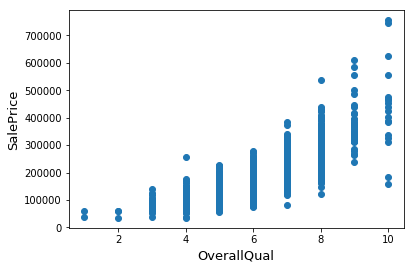

In [212]:
fig, ax = plt.subplots()
ax.scatter(x = encoded_data['OverallQual'], y = encoded_data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)
plt.show()

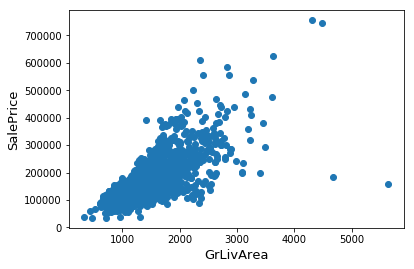

In [213]:
fig, ax = plt.subplots()
ax.scatter(x = encoded_data['GrLivArea'], y = encoded_data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [214]:
import numpy as np
from sklearn.decomposition import PCA

columns = ['GrLivArea', 'YearRemodAdd', 'TotalBsmtSF',
           'GarageArea','YearBuilt', 'YrSold', 'LotArea', 
           'GrLivArea', '1stFlrSF','OverallQual']

X = encoded_data[columns]

pca = PCA(n_components=2)
pca.fit(X)


print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

[0.99130335 0.00627806]
[381380.4370016  30350.6399328]


In [192]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Initial training
    model.fit(train_X, train_y)
    
    # Use the model to make predictions
    predicted_prices = model.predict(test_X)
    
   
    # Treat the test data in the same way as training data. In this case, pull same columns.
    #test_X = encoded_data[columns]
    

    
    # We will look at the predicted prices to ensure we have something sensible.
    #print(predicted_prices)

In [198]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

columns = ['GrLivArea', 'YearRemodAdd', 'TotalBsmtSF',
           'GarageArea','YearBuilt', 'YrSold', 'LotArea', 
           'GrLivArea', '1stFlrSF','OverallQual']

X = encoded_data[columns]
y = encoded_data.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
evaluate_model(RandomForestClassifier(max_depth=2, random_state=0), X_train, X_test, y_train, y_test)





0    208500
1    181500
2    223500
3    140000
4    250000
5    143000
6    307000
7    200000
8    129900
9    118000
Name: SalePrice, dtype: int64


In [193]:
my_submission = pd.DataFrame({'Id': encoded_test_data.Id, 'SalePrice': predicted_prices})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)